In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sglib.utils import load_example_data

def calculate_lower_bound(df):
    """
    Calculate the lower bound of a time series.
    """
    qmax = df.max()
    qmin = df.min()
    qmedian = df.median()
    tau = (qmax*qmin - qmedian**2) / (qmax + qmin - 2*qmedian)
    tau = tau if tau > 0 else 0
    return tau


def stedinger_normalization(df):
    """
    Normalize a time series using normalization technique in 
    Stedinger and Taylor (1982).
    """
    # Get lower bound; \hat{\tau} for each month
    norm_df = df.copy()
    tau_monthly = df.groupby(df.index.month).apply(calculate_lower_bound)
    for i in range(1, 13):
        tau = tau_monthly[i]
        
        # Normalize
        norm_df[df.index.month == i] = np.log(df[df.index.month == i] - tau)
    return norm_df, tau_monthly

def inverse_stedinger_normalization(df, tau_monthly):
    """
    Inverse normalize a time series using normalization technique in 
    Stedinger and Taylor (1982).
    """
    # Get lower bound; \hat{\tau} for each month
    norm_df = df.copy()
    for i in range(1, 13):
        tau = tau_monthly[i]
        
        # Normalize
        norm_df[df.index.month == i] = np.exp(df[df.index.month == i]) + tau
    
    return norm_df

class ThomasFieringGenerator():
    """
    From Thomas and Fiering, 1962.    
    Also described in Steinder and Taylor (1982).
    
    Usage:
    tf = ThomasFieringGenerator(Q_obs_monthly.iloc[:,2])
    Q_syn = tf.generate(n_years=10, n_realizations=10)
    """
    def __init__(self, Q, **kwargs):
        # Q should be pandas df or series with monthly index
        if Q.index.freq not in ['MS', 'M']:
            if Q.index.freq in ['D', 'W']:
                Q = Q.resample('MS').sum()
        
        self.Q_obs_monthly = Q 
        
        self.is_fit = False
        self.is_preprocessed = False
    
    def preprocessing(self, **kwargs):
        self.Q_norm, self.tau_monthly = stedinger_normalization(self.Q_obs_monthly)
        self.is_preprocessed = True
        return
        
    def fit(self, **kwargs):
        
        # monthly mean and std
        self.mu = self.Q_norm.groupby(self.Q_norm.index.month).mean()
        self.sigma = self.Q_norm.groupby(self.Q_norm.index.month).std()
        
        # monthly correlation between month m and m+1
        self.rho = self.mu.copy()
        for i in range(1, 13):
            first_month = i
            second_month = i+1 if i < 12 else 1
            first_month_flows = self.Q_norm[self.Q_norm.index.month == first_month]
            second_month_flows = self.Q_norm[self.Q_norm.index.month == second_month]
            if len(first_month_flows) > len(second_month_flows):
                first_month_flows = first_month_flows.iloc[1:]
            elif len(first_month_flows) < len(second_month_flows):
                second_month_flows = second_month_flows.iloc[:-1]
            lag1_r = pearsonr(first_month_flows.values, 
                              second_month_flows.values)
            
            self.rho[i] = lag1_r[0]
            
        self.is_fit = True
    
    def generate(self, 
                 n_years, 
                 **kwargs):
            
        # Generate synthetic sequences
        self.x_syn = np.zeros((n_years*12))
        for i in range(n_years):
            for m in range(12):
                prev_month = m if m > 0 else 12
                month = m + 1
                
                if (i==0) and (m==0):
                    self.x_syn[0] = self.mu[month] + np.random.normal(0, 1)*self.sigma[month]

                else:
                    
                    e_rand = np.random.normal(0, 1)
                    
                    self.x_syn[i*12+m] = self.mu[month] + \
                                        self.rho[month]*(self.sigma[month]/self.sigma[prev_month])*\
                                            (self.x_syn[i*12+m-1] - self.mu[prev_month]) + \
                                                np.sqrt(1-self.rho[month]**2)*self.sigma[month]*e_rand
                        
        # convert to df
        syn_start_year = self.Q_obs_monthly.index[0].year
        syn_start_date = f'{syn_start_year}-01-01'
        self.x_syn = pd.DataFrame(self.x_syn, 
                                index=pd.date_range(start=syn_start_date, 
                                                    periods=len(self.x_syn), freq='MS'))
        self.x_syn[self.x_syn < 0] = self.Q_norm.min()
        
        self.Q_syn = inverse_stedinger_normalization(self.x_syn, self.tau_monthly)
        self.Q_syn[self.Q_syn < 0] = self.Q_obs_monthly.min()
        return self.Q_syn
    
    def generate_ensemble(self, 
                          n_years, 
                          n_realizations = 1, 
                          **kwargs):
        
        if not self.is_preprocessed:
            self.preprocessing()
        if not self.is_fit:
            self.fit()
        
        # Generate synthetic sequences
        for i in range(n_realizations):
            Q_syn = self.generate(n_years)
            if i == 0:
                self.Q_syn_df = Q_syn
            else:
                self.Q_syn_df = pd.concat([self.Q_syn_df, Q_syn], 
                                          axis=1, ignore_index=True)
    
        return self.Q_syn_df


In [10]:
### Load demo data
test_site_idx = 0
Q_obs = load_example_data().iloc[:, test_site_idx].dropna()
Q_obs = Q_obs.loc[Q_obs > 0]
Q_obs_monthly = Q_obs.resample('MS').sum()

## ThomasFiering Model
tf = ThomasFieringGenerator(Q_obs_monthly)
Q_syn = tf.generate_ensemble(n_years=50, n_realizations=100)
Q_syn_tf = Q_syn.copy()


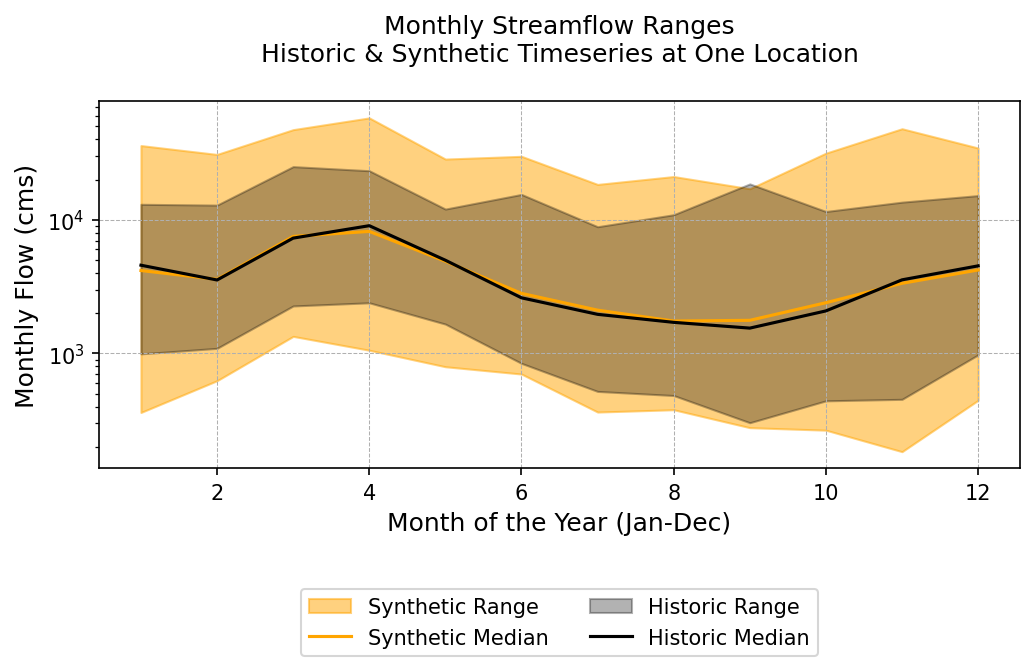

In [12]:
def plot_flow_ranges(Qh, Qs, 
                     timestep = 'daily',
                     units = 'cms', y_scale = 'log',
                     savefig = False, fig_dir = '.',
                     figsize = (7,5), colors = ['black', 'orange'],
                     title_addon = ""):
    """Plots the range of flow for historic and syntehtic streamflows for a specific timestep scale.
    
    Args:
        Qh (pd.Series): Historic daily streamflow timeseries. Index must be pd.DatetimeIndex. 
        Qs (pd.DataFrame): Synthetic daily streamflow timeseries realizations. Each column is a unique realization. Index must be pd.DatetimeIndex.
        timestep (str, optional): The timestep which data should be aggregated over. Defaults to 'daily'. Options are 'daily', 'weekly', or 'monthly'.
        units (str, optional): Streamflow units, for axis label. Defaults to 'cms'.
        y_scale (str, optional): Scale of the y-axis. Defaults to 'log'.
        savefig (bool, optional): Allows for png to be saved to fig_dir. Defaults to False.
        fig_dir (str, optional): Location of saved figure output. Defaults to '.' (working directory).
        figsize (tuple, optional): The figure size. Defaults to (4,4).
        colors (list, optional): List of two colors for historic and synthetic data respectively. Defaults to ['black', 'orange'].
        title_addon (str, optional): Text to be added to the end of the title. Defaults to "".
    """


    # Assert formatting matches expected
    assert(type(Qh.index) == pd.DatetimeIndex), 'Historic streamflow (Qh) should have pd.DatatimeIndex.'
    assert(type(Qs.index) == pd.DatetimeIndex), 'Synthetic streamflow (Qh) should have pd.DatatimeIndex.'

    # Handle conditional datetime formatting
    if timestep == 'daily':
        h_grouper = Qh.index.dayofyear
        s_grouper = Qs.index.dayofyear
        x_lab = 'Day of the Year (Jan-Dec)'
    elif timestep == 'monthly':
        h_grouper = Qh.index.month
        s_grouper = Qs.index.month
        x_lab = 'Month of the Year (Jan-Dec)'
    elif timestep == 'weekly':
        h_grouper = pd.Index(Qh.index.isocalendar().week, dtype = int)
        s_grouper = pd.Index(Qs.index.isocalendar().week, dtype = int)
        x_lab = 'Week of the Year (Jan-Dec)'
    else:
        print('Invalid timestep input. Options: "daily", "monthly", "weekly".')
        return

    # Find flow ranges
    s_max = Qs.groupby(s_grouper).max().max(axis=1)
    s_min = Qs.groupby(s_grouper).min().min(axis=1)
    s_median = Qs.groupby(s_grouper).median().median(axis=1)
    h_max = Qh.groupby(h_grouper).max()
    h_min = Qh.groupby(h_grouper).min()
    h_median = Qh.groupby(h_grouper).median()
  
    ## Plotting  
    fig, ax = plt.subplots(figsize = figsize, dpi=150)
    xs = h_max.index
    ax.fill_between(xs, s_min, s_max, color = colors[1], label = 'Synthetic Range', alpha = 0.5)
    ax.plot(xs, s_median, color = colors[1], label = 'Synthetic Median')
    ax.fill_between(xs, h_min, h_max, color = colors[0], label = 'Historic Range', alpha = 0.3)
    ax.plot(xs, h_median, color = colors[0], label = 'Historic Median')
    
    ax.set_yscale(y_scale)
    ax.set_ylabel(f'{timestep.capitalize()} Flow ({units})', fontsize=12)
    ax.set_xlabel(x_lab, fontsize=12)

    ax.legend(ncols = 2, fontsize = 10, bbox_to_anchor = (0, -.5, 1.0, 0.2), loc = 'upper center')    
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.set_title(f'{timestep.capitalize()} Streamflow Ranges\nHistoric & Synthetic Timeseries at One Location\n{title_addon}')
    plt.tight_layout()
    
    if savefig:
        plt.savefig(f'{fig_dir}/flow_ranges_{timestep}.png', dpi = 150)
    return

## Usage
plot_flow_ranges(Q_obs_monthly, Q_syn, timestep='monthly', savefig=False)

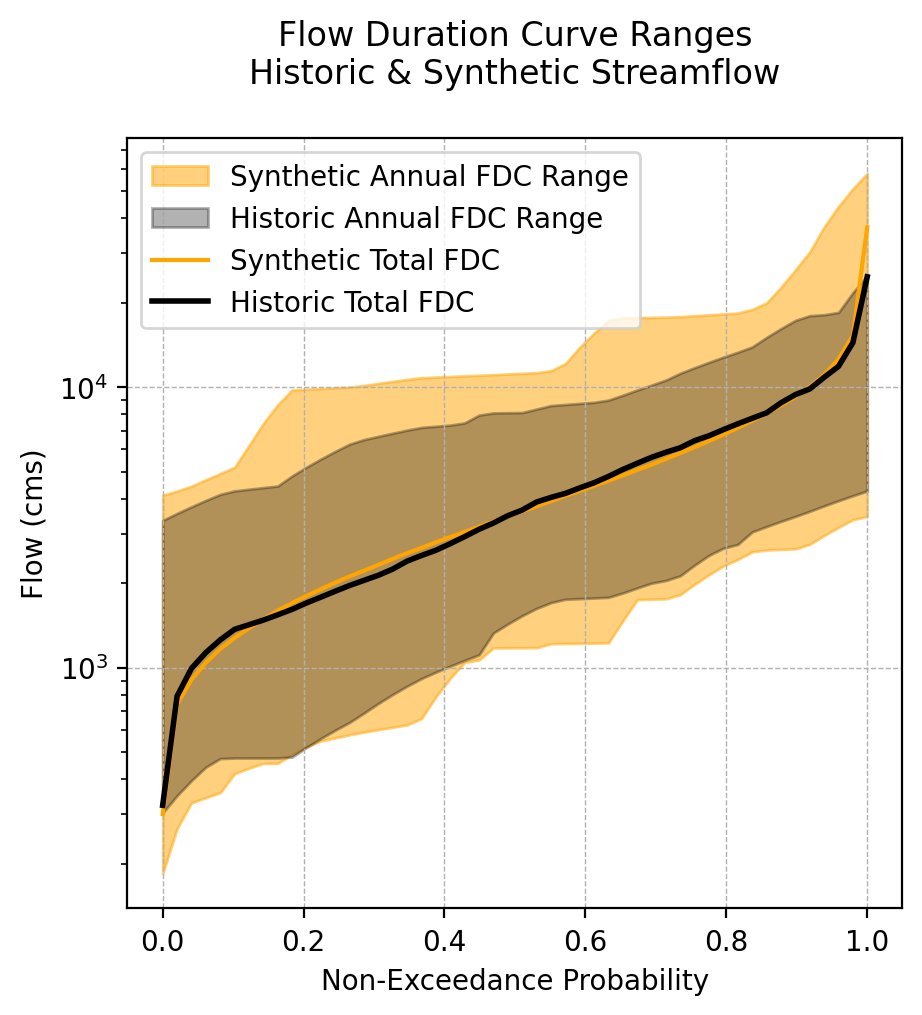

In [15]:
def plot_fdc_ranges(Qh, Qs, 
                    units = 'cms', y_scale = 'log',
                    savefig = False, fig_dir = '.',
                    figsize = (5,5), colors = ['black', 'orange'],                   
                    title_addon = ""):
    """Plots the range and aggregate flow duration curves for historic and synthetic streamflows.
    
    Args:
        Qh (pd.Series): Historic daily streamflow timeseries. Index must be pd.DatetimeIndex. 
        Qs (pd.DataFrame): Synthetic daily streamflow timeseries realizations. Each column is a unique realization. Index must be pd.DatetimeIndex.
        units (str, optional): Streamflow units, for axis label. Defaults to 'cms'.
        y_scale (str, optional): Scale of the y-axis. Defaults to 'log'.
        savefig (bool, optional): Allows for png to be saved to fig_dir. Defaults to False.
        fig_dir (str, optional): Location of saved figure output. Defaults to '.' (working directory).
        figsize (tuple, optional): The figure size. Defaults to (4,4).
        colors (list, optional): List of two colors for historic and synthetic data respectively. Defaults to ['black', 'orange'].
        title_addon (str, optional): Text to be added to the end of the title. Defaults to "".
    """
    
    ## Assertions
    assert(type(Qs) == pd.DataFrame), 'Synthetic streamflow should be type pd.DataFrame.'
    assert(type(Qh.index) == pd.DatetimeIndex), 'Historic streamflow (Qh) should have pd.DatatimeIndex.'
    assert(type(Qs.index) == pd.DatetimeIndex), 'Synthetic streamflow (Qh) should have pd.DatatimeIndex.'

    
    # Calculate FDCs for total period and each realization
    nonexceedance = np.linspace(0.0001, 0.9999, 50)
    s_total_fdc = np.quantile(Qs.values.flatten(), nonexceedance)
    h_total_fdc = np.quantile(Qh.values.flatten(), nonexceedance) 
    
    s_fdc_max = np.zeros_like(nonexceedance)
    s_fdc_min = np.zeros_like(nonexceedance)
    h_fdc_max = np.zeros_like(nonexceedance)
    h_fdc_min = np.zeros_like(nonexceedance)

    annual_synthetics = Qs.groupby(Qs.index.year)
    annual_historic = Qh.groupby(Qh.index.year)

    for i, quant in enumerate(nonexceedance):
            s_fdc_max[i] = annual_synthetics.quantile(quant).max().max()
            s_fdc_min[i] = annual_synthetics.quantile(quant).min().min()
            h_fdc_max[i] = annual_historic.quantile(quant).max()
            h_fdc_min[i] = annual_historic.quantile(quant).min()
    
    ## Plotting
    fig, ax = plt.subplots(figsize=figsize, dpi=200)
    
    #for quant in syn_fdc_quants:
    ax.fill_between(nonexceedance, s_fdc_min, s_fdc_max, color = colors[1], label = 'Synthetic Annual FDC Range', alpha = 0.5)
    ax.fill_between(nonexceedance, h_fdc_min, h_fdc_max, color = colors[0], label = 'Historic Annual FDC Range', alpha = 0.3)

    ax.plot(nonexceedance, s_total_fdc, color = colors[1], label = 'Synthetic Total FDC', alpha = 1)
    ax.plot(nonexceedance, h_total_fdc, color = colors[0], label = 'Historic Total FDC', alpha = 1, linewidth = 2)

    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.set_yscale(y_scale)
    ax.set_ylabel(f'Flow ({units})')
    ax.set_xlabel('Non-Exceedance Probability')
    ax.legend(fontsize= 10)
    ax.grid(True, linestyle='--', linewidth=0.5)
    
    plt.title(f'Flow Duration Curve Ranges\nHistoric & Synthetic Streamflow\n{title_addon}')
    if savefig:
        plt.savefig(f'{fig_dir}/flow_duration_curves_{title_addon}.png', dpi=200)
    plt.show()
    return

## Usage 
plot_fdc_ranges(Q_obs_monthly, Q_syn, savefig = False)